#Regulized least square loss minimizer

$\Large{Question 2(1)}$   

In [1]:

import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer as timer
np.random.seed(1000)

In [2]:
A=np.random.randn(1000,10)
epi=np.random.randn(1000,1)  #epi= episolon


In [3]:
x=[]
for i in range(1,11):
  if i%2==0:  #even nunber
    x.append(np.random.uniform(i,i+1))
  if i%2!=0:  # odd number
    x.append(np.random.uniform(-i-1,-i))
print(x)

[-1.5598060982531905, 2.3304600657948655, -3.6795264016693583, 4.690106332295438, -5.791543695407358, 6.066830606319292, -7.250688337950498, 8.29645037615345, -9.919538982700145, 10.753574141825613]


In [4]:
x_bar=np.array(x)  #total even and the odd value
x_bar=x_bar.reshape(10,1)

In [5]:
x_bar.shape
print(x_bar)
A_x=A@x_bar   #find the A*x_bar

[[-1.5598061 ]
 [ 2.33046007]
 [-3.6795264 ]
 [ 4.69010633]
 [-5.7915437 ]
 [ 6.06683061]
 [-7.25068834]
 [ 8.29645038]
 [-9.91953898]
 [10.75357414]]


In [6]:
np.matmul(A,x_bar).shape
y=A_x+epi   #epi= episolon

In [7]:
def evalf(x,lam): # question 1(1)
  assert type(x) is np.ndarray
  fval = np.linalg.norm(np.matmul(A,x) - y)
  fval = 0.5 * (fval)**2+(lam/2)*np.matmul(x.T,x)
  return (fval)


In [8]:
def evalg(x,lam):  #gradient
  assert type(x) is np.ndarray
  grad=(lam*x+np.matmul(A.T, np.matmul(A, x) - y))
  return grad

In [9]:
def evalh(x, lam):  # hessian

    assert type(x) is np.ndarray
    return np.matmul(A.T, A) + lam * np.identity(A.shape[1])

In [10]:
def compute_B_k(pr, y, B_k):  #compute the b_k
  assert type(pr) is np.ndarray and len(pr) == n
  assert type(B_k) is np.ndarray and len(y) == n
  mu = 1 / np.dot(np.squeeze(np.asarray(y)), np.squeeze(np.asarray(pr)))
  I = np.identity(n)
  a_1 = np.outer(np.multiply(mu, pr), y.T)
  a_2 = np.outer(np.multiply(mu, y), pr.T)
  b_k = np.add(np.matmul(np.matmul(I - a_1, B_k), I - a_2), np.outer(np.multiply(mu, pr), pr.T) )
  return b_k

In [11]:
#line search type
EXACT_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH = 2

In [12]:
def compute_D_k(x):   #compute the d_k
  assert type(x) is np.ndarray
  mat = evalh(x)
  return np.linalg.inv(mat)

In [13]:
def compute_steplength_backtracking_scaled_direction(x, lam,gradf, alpha_start, rho, gamma, B_k):
  assert type(x) is np.ndarray
  assert type(gradf) is np.ndarray
  assert type(alpha_start) is float and alpha_start>=0.
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0.
  alpha = alpha_start
  p = - gradf
  D_k = B_k   # for scaled b_k = d_k

  while evalf(x + alpha*np.matmul(D_k,p),lam) > evalf(x,lam) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha

In [14]:
def find_minimizer_Newtonmethod(start_x,lam, tol, line_search_type, *args):  #here we use the newton method
  assert type(start_x) is np.ndarray
  assert type(tol) is float and tol>=0

  x = start_x
  g_x = evalg(x,lam)
  h_x = evalh(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args.'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args.'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  x_array_newton = []
  f_array_newton = []
  while (np.linalg.norm(g_x) > tol):
    D_k = np.linalg.inv(evalh(x,lam))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,lam, g_x, alpha_start, rho, gamma, D_k)

    else:
      raise ValueError('Line search type unknown. Please check!')
    x_array_newton.append(math.log(np.linalg.norm(x - x_bar)))
    f_array_newton.append(math.log(np.linalg.norm(evalf(x,lam) - evalf(x_bar,lam))))
    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x)))
    k = k + 1
    g_x = evalg(x,lam)
  return x,  k, x_array_newton, f_array_newton

In [15]:
def find_minimizer_BFGS_scaling(start_x, lam,tol, line_search_type, *args):
  assert type(start_x) is np.ndarray
  assert type(tol) is float and tol>=0

  x = start_x
  g_x = evalg(x,lam)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  B_k = np.identity(n)
  x_old = x
  x_array_bfgs = []
  f_array_bfgs = []
  while (np.linalg.norm(g_x) > tol):
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x_old,lam, g_x, alpha_start, rho, gamma, B_k)
    else:
      raise ValueError('Line search type unknown. Please check!')
    x_array_bfgs.append(math.log(np.linalg.norm(x_old - x_bar)))
    f_array_bfgs.append(math.log(np.linalg.norm(evalf(x_old,lam) - evalf(x_bar,lam))))
    x_new = np.subtract(x_old, np.multiply(step_length, np.matmul(B_k,g_x)))
    g_x = evalg(x_new,lam)
    s = np.subtract(x_new, x_old)
    y = np.subtract(evalg(x_new,lam), evalg(x_old,lam))
    B_k = compute_B_k(s, y, B_k)
    x_old = x_new
    k = k + 1
  return x_new, k, x_array_bfgs, f_array_bfgs

In [16]:

from timeit import default_timer as timer

In [17]:
n = 10 # number of the feature
my_start_x = np.array([0 for i in range(10)])
my_start_x = my_start_x.reshape(10,1)
my_tol  = 1e-5
alpha =0.99
rho=0.5
gamma=0.5

In [33]:
my_tol= 1e-5
k2=[]
xvalues1=[]
fvalues1=[]
time_taken_newton=[]
lam1=np.array([10**(-3),10**(-2),10**(-1),1])
for i in lam1:
  start1=timer()
  x, k, x_array_newton, f_array_newton = find_minimizer_Newtonmethod(my_start_x,i, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  end1=timer()
  print('for lambda',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(f(x^k)-f(x^*)):',f_array_newton)
  k2.append(k)
  xvalues1.append(x_array_newton)
  fvalues1.append(f_array_newton)
  time_taken_newton.append(end1-start1)

for lambda 0.001 :
we have minimizer: [[-1.52615618]
 [ 2.3593343 ]
 [-3.71408397]
 [ 4.65508056]
 [-5.7922779 ]
 [ 6.05589718]
 [-7.25518231]
 [ 8.32368594]
 [-9.87347598]
 [10.71877202]] 
no. of iterations: 6 
 log(x^k-x^*): [3.0537214707825258, -1.3563390606229533, -2.3701359530869146, -2.3777986332629815, -2.377873279159688, -2.3778736522889607] 
 log(f(x^k)-f(x^*)): [12.439425531440172, 3.0605067455101764, 1.3650807629364912, 1.3657254517435553, 1.3657255161917117, 1.3657255161964261]
for lambda 0.01 :
we have minimizer: [[-1.52614455]
 [ 2.35932028]
 [-3.71405267]
 [ 4.65503097]
 [-5.79223521]
 [ 6.05584892]
 [-7.25512314]
 [ 8.32362251]
 [-9.87339781]
 [10.71868531]] 
no. of iterations: 5 
 log(x^k-x^*): [3.0537214707825258, -1.3557167903327, -2.369434075602434, -2.3771271747192735, -2.377202133058459] 
 log(f(x^k)-f(x^*)): [12.439417528139124, 3.060221198938182, 1.366583882699989, 1.367227598366992, 1.3672276627178457]
for lambda 0.1 :
we have minimizer: [[-1.52602828]
 [ 2.359

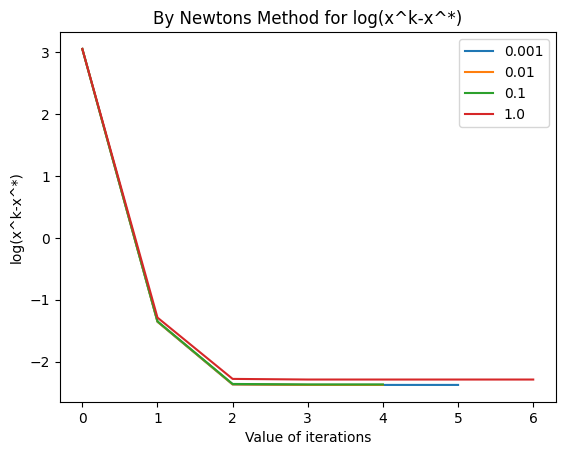

In [19]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],xvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By Newtons Method for log(x^k-x^*)')
  plt.legend(lam1)
plt.show()

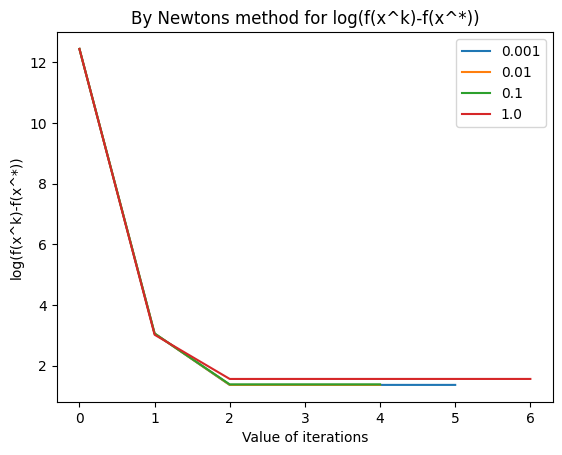

In [20]:
for j in range(len(k2)):
  plt.plot([i for i in range(k2[j])],fvalues1[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.legend(lam1)
  plt.title('By Newtons method for log(f(x^k)-f(x^*))')
plt.show()


$\large\textbf{Ans 2.4 : }$  here we saw above in both graphs that the sequence are converging towards a particular value. hence both sequences are Q-linear,Q superlinear and Q-quadratic . Also we can see that no. of iterations decrease constantly. and  Also we can see that no. of iterations decrease constantly. We see as the value of lambda reduces the variance of the graph.

#Question 2.5

In [21]:
n = 10 # number of the feature
my_start_x = np.array([0 for i in range(10)])
my_start_x = my_start_x.reshape(10,1)

In [35]:
alpha = 0.99
rho = 0.5
gamma = 0.5
my_tol= 1e-5
k3=[]
xvalues2=[]
fvalues2=[]
time_taken_bfgs=[]
lam1=np.array([10**(-3),10**(-2),10**(-1),1])
for i in lam1:
  start=timer()
  x, k, x_array_newton, f_array_newton = find_minimizer_BFGS_scaling(my_start_x,i, my_tol, BACKTRACKING_LINE_SEARCH, alpha, rho, gamma)
  end=timer()
  print('for lambda',i,':\nwe have minimizer:',x ,'\nno. of iterations:',k, '\n log(x^k-x^*):',x_array_newton , '\n log(f(x^k)-f(x^*)):',f_array_newton)
  k3.append(k)
  xvalues2.append(x_array_newton)
  fvalues2.append(f_array_newton)
  time_taken_bfgs.append(end-start)

for lambda 0.001 :
we have minimizer: [[-1.52615618]
 [ 2.3593343 ]
 [-3.71408397]
 [ 4.65508056]
 [-5.7922779 ]
 [ 6.05589718]
 [-7.2551823 ]
 [ 8.32368594]
 [-9.87347598]
 [10.71877201]] 
no. of iterations: 19 
 log(x^k-x^*): [3.0537214707825258, 2.271681607631065, 2.2479705413401203, 2.2428879062717924, 2.0772806139888202, 1.1919212406234, 1.1652415096169335, 1.1587105604096157, 0.10915238802131715, -0.9095710705654838, -0.9088633353145893, -0.9091071845436723, -1.9312998107548667, -2.222319232268771, -2.3768491249987678, -2.377863849480131, -2.377873931126748, -2.3778739374273794, -2.377873984713641] 
 log(f(x^k)-f(x^*)): [12.439425531440172, 10.857577028594049, 10.833398311958927, 10.823267728934495, 10.465329081524464, 8.703950679773541, 8.65460433891083, 8.642727854255725, 6.441085930070679, 4.313329562682816, 4.24315716028461, 4.23626464534906, -0.4213655354741584, 1.1503849985954135, 1.3657069488868234, 1.3657255143413902, 1.365725516197935, 1.3657255161979494, 1.3657255161980

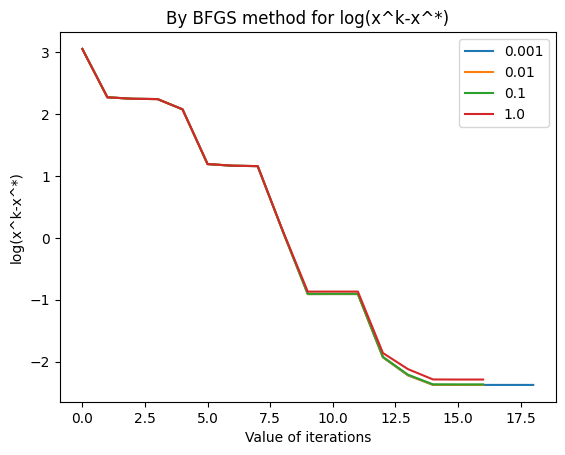

In [23]:
for j in range(len(k3)):
  plt.plot([i for i in range(k3[j])],xvalues2[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(x^k-x^*)')
  plt.title('By BFGS method for log(x^k-x^*)')
  plt.legend(lam1)
plt.show()

In [24]:
for j in range(len(k3)):
  plt.plot([i for i in range(k3[j])],fvalues2[j])
  plt.xlabel('Value of iterations')
  plt.ylabel('log(f(x^k)-f(x^*))')
  plt.title('By BFGS Method for log(f(x^k)-f(x^*))')
  plt.legend(lam1)
plt.show()

$\large\textbf{Observation: }$ here we saw above in both graphs that the sequence are converging towards a particular value. hence both sequences are Q-linear,Q superlinear and Q-quadratic . Also we can see that no. of iterations decrease constantly. and also we saw  in BFGS method convergence is slow as compared to newtons method. Hence the value of iterations increases or converges slowly for BFGS method.
We can see by running for different number of rows of A that time taken by both the methods increases with considerable amount.As we see the values of no. of rows increases then time taken also increases.

#Question 2.6

In [31]:
print("Time taken by Newton's method: ", time_taken_bfgs)  # foer the compare purpose we print the value
print("Time taken by BFGS: ", time_taken_newton)

Time taken by Newton's method:  [0.07034494300023653, 0.047623270000258344, 0.03333039699919027, 0.059417595000013534]
Time taken by BFGS:  [0.006303770000158693, 0.005889375000151631, 0.005203645000619872, 0.005861259000084829]


In [39]:
print('newtow method at lammda=([0.001,0.01,0.1,1]):', fvalues1)

newtow method at lammda=([0.001,0.01,0.1,1]): [[12.439425531440172, 3.0605067455101764, 1.3650807629364912, 1.3657254517435553, 1.3657255161917117, 1.3657255161964261], [12.439417528139124, 3.060221198938182, 1.366583882699989, 1.367227598366992, 1.3672276627178457], [12.439337491605544, 3.057277572236876, 1.3819391052355827, 1.3825729645504146, 1.382573027916198], [12.438536773750664, 3.018703851992157, 1.5617818062464517, 1.5623109388668852, 1.5623109917661677, 1.5623109917701004, 1.5623109917710776]]


In [40]:
print('BFGS method at lammda=([0.001,0.01,0.1,1]):', fvalues2)

BFGS method at lammda=([0.001,0.01,0.1,1]): [[12.439425531440172, 10.857577028594049, 10.833398311958927, 10.823267728934495, 10.465329081524464, 8.703950679773541, 8.65460433891083, 8.642727854255725, 6.441085930070679, 4.313329562682816, 4.24315716028461, 4.23626464534906, -0.4213655354741584, 1.1503849985954135, 1.3657069488868234, 1.3657255143413902, 1.365725516197935, 1.3657255161979494, 1.3657255161980508], [12.439417528139124, 10.85754969897045, 10.833370912084437, 10.823240382930555, 10.465297755425986, 8.703873676736256, 8.6545264209271, 8.642649987985864, 6.441001708960091, 4.313196072260371, 4.243020965648608, 4.236127782202629, -0.4320131060759377, 1.1524429050422158, 1.3672091379102245, 1.3672276608718659, 1.3672276627240885], [12.439337491605544, 10.857276361646642, 10.833096871179523, 10.822966880449435, 10.46498444382442, 8.703103378268384, 8.653746957058148, 8.64187103746993, 6.440156626985307, 4.311836659351043, 4.241632718826631, 4.234732663359779, -0.548276882743984

**Observation** in the above we have print the value of the newton and the BFGS methom at different lemda and also we print the value of the time taken by the each lemda